# Movies Data Project

## Miri Hazanov, Alon Maharshak

### First step-collect and preapre the data



#### During this project we will work with the "Cornell Movie-Dialogs Corpus" created by the Cornell University

Our first step is to understand the data.

* Import the relevent Packeges 
* Open the movie titles files and the movie lines file.

In [1]:
import pandas as pd
import nltk
import re
import string 

fileName='C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/cornell movie-dialogs corpus/movie_lines.txt'
with open(fileName) as f:
    lines = f.readlines()
fileName='C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/cornell movie-dialogs corpus/movie_titles_metadata.txt'
with open(fileName) as f:
    titles = f.readlines()

Now lets print an exapmle so we can see how our meta data and raw data looks like

In [2]:
print(titles[0])
print(lines[0])

m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance']

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!



As we can see, the data has a '+++$+++' seperator, so now we can start work on the data.

Our stages we'll be:
* Create a list of each genre using the generes list in the titles file
* Get the title with the most lines in each genre so well have a lot of lines to work with
* Clean the data, getting only the movie line after cleaning of lower case and other unnecessary marks.
* Create a csv file with the Line, movie name and movie genre.

### Create list function:
returns a list of all the movie id's that are relevent to a selected genre.

In [3]:
def createList(genre):
    ans=[]
    for title in titles:
        att=title.split('+++$+++')
        if genre in att[5]:
            ans.append(att[0])
    return ans

### Get the movie with the most lines function

In [4]:
def getMaxLines(movielist):
    x=0
    maxMovie=''
    for movie in movielist:
        movieline='+++$+++ '+movie+'+++$+++'
        movieLines=[line for line in lines if movieline in line]
        if len(movieLines)>x:
            x=len(movieLines)
            maxMovie=movie
    return maxMovie

### Clean the movie data function

* takes the raw line, strips only the movie line.
* remove from the movie line unnecessary marks and swtich to lower case 
* strip the movie name 

Returns a tuple of the movie name + a list of all the movie lines(clean)

In [5]:
def cleanMovie(movie):
    num=int(movie[1:])
    movieLinesRaw=[line for line in lines if '+++$+++ '+ movie+'+++$+++' in line]
    MovieLinesClean=[]
    results=[]
    for line in movieLinesRaw:
         att=line.split('+++$+++')
         MovieLinesClean.append(att[4])
    returnLines=[]
    att=titles[num].split('+++$+++')
    results.append(att[1])
    for line in MovieLinesClean:
        line=line.lower()
        for char in string.punctuation:
            if char!="'":
                line = line.replace(char, ' ')
        line=' '.join(line.split())
        returnLines.append(line)
    
    results.append(returnLines)
    return results

### Create CSV files function:

In [6]:
def makeCsv(movie,name,genre):
    df=pd.DataFrame()
    df['lines']=movie
    df['name']=name
    df['type']=genre
    df.to_csv('C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/'+genre+'Lines.csv')
    return df

Now we can activate all of the stages for all the 3 genres and concatene them into one csv file:

In [7]:
adventureList=createList('adventure') 
dramaList=createList('drama') 
comedyList=createList('comedy') 

maxAdventure=getMaxLines(adventureList)
maxDrama=getMaxLines(dramaList)
maxComedy=getMaxLines(comedyList)

movieDrama=cleanMovie(maxDrama)
movieComedy=cleanMovie(maxComedy)
movieAdventure=cleanMovie(maxAdventure)

dramaDf=makeCsv(movieDrama[1],movieDrama[0],'Drama')
comedyDf=makeCsv(movieComedy[1],movieComedy[0],'Comedy')
AdventureDf=makeCsv(movieAdventure[1],movieAdventure[0],'Adventure')

result = pd.concat([dramaDf,comedyDf,AdventureDf])
#result.to_csv('C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/MoviesLines.csv')

## Second part of the project:
### building calssification Model

In this part we will take the list of movie lines that we collected earlier and try to build a classification model out of it.

First we'll need to transform the vocabulary of words into features- we'll use the Bag of words technique.
We'll use the CountVectorizer package and use a "word" analyzer to get maximun features for our model.

We picked the max_features parameter to be as big as 5000 words so all of the words will be taken into considiration.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
train_data_features = vectorizer.fit_transform(result['lines'])
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
print(train_data_features.shape)

(3997, 2886)


### Build the Model:

Now that we build our BOW we can train a model using the folloing steps:
1. Divide the data into train and test.
2. define the name of the movie as the classification catagories.
3. Import the relevant models and train each of them.
4. compare and choose the most efficient one.

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn import neighbors 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

np.random.seed(123)
x = np.random.rand(len(result['lines'])) < 0.8
train_x = train_data_features[x]
test_x = train_data_features[~x]
train_y = result.loc[x,"name"]
test_y = result.loc[~x,"name"]

forest = RandomForestClassifier(n_estimators = 100) 
model = forest.fit( train_x, train_y )
forestScore=model.score(test_x,test_y)
print("RandomForestClassifier: {}".format(forestScore))

knn = neighbors.KNeighborsClassifier(3) 
model=knn.fit(train_x, train_y) 
knnScore = model.score(test_x,test_y) 
print("knn: {}".format(knnScore))

svm = svm.LinearSVC() 
model=svm.fit(train_x, train_y) 
svmScore=model.score(test_x,test_y)
print("svm: {}".format(svmScore))

tree = DecisionTreeClassifier()
model = tree.fit( train_x, train_y )
treeScore=model.score(test_x,test_y)
print("DecisionTreeClassifier: {}".format(treeScore))

Reg = LogisticRegression()
model = Reg.fit( train_x, train_y )
RegScore=model.score(test_x,test_y)
print("LogisticRegression: {}".format(RegScore))

RandomForestClassifier: 0.6326276463262764
knn: 0.48816936488169366
svm: 0.6737235367372354
DecisionTreeClassifier: 0.5529265255292652
LogisticRegression: 0.6787048567870486


### Visualization:

**We can see from the plot below that the best models are Linear SVM and LogisticRegression**

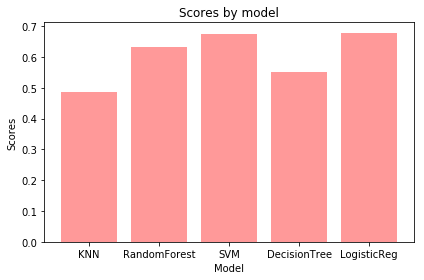

In [108]:
import matplotlib.pyplot as plt
data=[knnScore,forestScore,svmScore,treeScore,RegScore]
fig, ax = plt.subplots()
ax.set_ylabel('Scores')
plt.xlabel('Model')
ax.set_title('Scores by model')
index = np.arange(5)
plt.bar(index,data,alpha=0.4, color='r',label='Model')
ax.set_xticklabels(('G1', 'KNN', 'RandomForest', 'SVM', 'DecisionTree','LogisticReg'))
plt.tight_layout()
plt.show()